In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
batch_size=4
device=torch.device("cuda:0")


In [9]:
#Model Architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout=nn.Dropout(0.25)
        self.cv1=nn.Conv2d(3,32,5,padding=2)
        self.pool=nn.MaxPool2d(2,2)
        self.cv2=nn.Conv2d(32,64,5,padding=2)
        self.pool2=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*8*8,1000)
        self.fc2=nn.Linear(1000,500)
        self.fc3=nn.Linear(500,100)
        self.dropout2=nn.Dropout(0.25)
        self.fc4=nn.Linear(100,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.cv1(x)))
        x=self.pool2(F.relu(self.cv2(x)))
        x=x.view(-1,64*8*8)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))               
        
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.dropout2(x)
        x=self.fc4(x) #no need to apply activation function as CrossEntropyLoss has already softmax activation function
        return x
        

In [11]:
#Download dataset
transform=transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
train_dataset=torchvision.datasets.CIFAR10(root='.',train=True,download=True,transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='.',train=False,download=True,transform=transform)

Using downloaded and verified file: .\cifar-10-python.tar.gz
Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
#Create dataset
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truch')

In [5]:
it=iter(train_loader)
x,y=next(it)
print(x[:2])
print(y[:2])

tensor([[[[-1.0000, -1.0000, -1.0000,  ...,  0.0667,  0.1059, -1.0000],
          [-0.0588,  0.0588,  0.1529,  ...,  0.0824,  0.0588, -1.0000],
          [-0.1216, -0.0980,  0.0588,  ..., -0.0039,  0.0980, -1.0000],
          ...,
          [-1.0000, -0.3725, -0.4118,  ..., -0.2314, -0.2784, -0.1843],
          [-1.0000, -0.3412, -0.5529,  ..., -0.2784, -0.3020, -0.2863],
          [-1.0000, -0.4039, -0.6078,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.0588,  0.0588, -1.0000],
          [-0.1373, -0.0196,  0.0745,  ..., -0.0196,  0.0275, -1.0000],
          [-0.1216, -0.1608, -0.0039,  ..., -0.0431,  0.0275, -1.0000],
          ...,
          [-1.0000, -0.3647, -0.4118,  ..., -0.3333, -0.3255, -0.2627],
          [-1.0000, -0.3098, -0.5373,  ..., -0.3882, -0.3961, -0.3255],
          [-1.0000, -0.3569, -0.5765,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.5059, -0.4275, -1.0000],
          [-0.5608, -0.4588, -

In [7]:
#Training
epoch=100
i=0
t=0
early_stopping=0
learning_rate=0.001
model=ConvNet().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
for j in range(epoch):
    if(early_stopping==10):
        print('Early Stopping :)')
        break
    i+=1
    correct_samples=0
    total_samples=0
    for (images,labels) in tqdm(train_loader):
        images=images.to(device)
        labels=labels.to(device)
        output=model(images)
        loss=criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,prediction=torch.max(output,1)
        total_samples+=labels.size(0)
        correct_samples+=(prediction==labels).sum().item()
        
    Training_accuracy=100.0 * correct_samples/total_samples
    if(abs(t-Training_accuracy)<=learning_rate):
        early_stopping+=1
    print(f'Epoch:{i}',f'Training Accuracy: {Training_accuracy} %')       
    t=Training_accuracy   
    

 24%|██████████████████                                                          | 2967/12500 [00:25<01:21, 116.38it/s]


KeyboardInterrupt: 

In [34]:
#To Save
torch.save(model.state_dict(),'model.pth')

In [3]:
#TO Load
model=ConvNet().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [17]:
#Plot architecture
images,labels=next(iter(train_loader))
writer=SummaryWriter()
writer.add_graph(model,images)
writer.close()

In [38]:
#Testing
tb=SummaryWriter()
with torch.no_grad():
    n_correct=0
    n_samples=0
    n_class_correct=[0 for i in range(10)]
    n_class_samples=[0 for i in range(10)]
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        output=model(images)
        _, predicted = torch.max(output,1)
        n_samples+=labels.size(0)
        n_correct+=(predicted == labels).sum().item()
        for i in range(batch_size):
            label=labels[i]
            pred=predicted[i]
            if(label==pred):
                n_class_correct[label]+=1
            n_class_samples[label]+=1
    acc=100.0 * n_correct/n_samples
    print(f'Accuracy of the network:{acc} %')
    tb.add_scalar('Accuracy',Training_accuracy,)

Accuracy of the network:77.82 %


truch


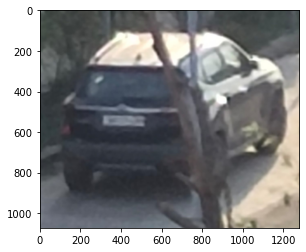

In [12]:
#Evaluation
from PIL import Image
import matplotlib.image as mpimg
image=Image.open('Car.jpg')
T=transforms.Resize((32,32))
resized_img=T(image)
T1=transforms.ToTensor()
image_inp=T1(resized_img)
image_inp=image_inp[None,:]
image_inp=image_inp.to(device)
output=model(image_inp)
_,prediction=torch.max(output,1)

a=plt.imread('Car.jpg')
plt.imshow(a)
print(classes[prediction])